# Building the final scratch model

In [105]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Loading image metadata

In [2]:
def get_image_meta(data_path):
    """Retrieve basic metadata (file_path, category)"""
    
    file_meta = []

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)

            attrs = {
                'category': name,
                'file_path': image_filepath,
            }
            file_meta.append(attrs)

    return file_meta 

In [3]:
data_file_path = "../data/clean_fer_2013/"

In [4]:
train_data_folder = data_file_path + "train/"

meta_train = get_image_meta(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head()

,category,file_path
0,sad,../data/clean_fer_2013/train/sad/Training_8912...
1,sad,../data/clean_fer_2013/train/sad/Training_7374...
2,sad,../data/clean_fer_2013/train/sad/Training_9509...
3,sad,../data/clean_fer_2013/train/sad/Training_7259...
4,sad,../data/clean_fer_2013/train/sad/Training_3215...


In [5]:
val_data_folder = data_file_path + "validation/"

meta_val = get_image_meta(val_data_folder)

df_meta_val = pd.DataFrame(meta_val)
df_meta_val.head()

,category,file_path
0,sad,../data/clean_fer_2013/validation/sad/PublicTe...
1,sad,../data/clean_fer_2013/validation/sad/PublicTe...
2,sad,../data/clean_fer_2013/validation/sad/PublicTe...
3,sad,../data/clean_fer_2013/validation/sad/PublicTe...
4,sad,../data/clean_fer_2013/validation/sad/PublicTe...


## Base Scratch Model Configuration

Here I rebuild the base model I built earlier.

In [6]:
input_shape = (48,48,1)
num_categories = 7 # we have 7 emotions

base_model = tf.keras.Sequential([
    keras.layers.InputLayer(shape=input_shape),

    # First Convolutional Layer (32 filters)
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer (64 filters)
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer (128 filters)
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),

    # Final output layer
    keras.layers.Dense(num_categories, activation='softmax') 
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

base_model.summary()

I0000 00:00:1737985218.402702     696 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,335 (2.64 MB)

 Trainable params: 691,335 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

## Preparing the datasets for training

I need a `label_encoder` to one-hot-encode the categories (which are currently in string format).

I have also added a `preprocess_input` function. At the moment this normalizes the image (converting all pixels into a [0,1] range) but it can be expanded in the future to perform additional steps e.g. to resize images and convert images to grayscale.

I shuffle the dataset to prevent any kind of order bias.

I use `prefetch` to improve performance: it will start preparing the next batch of data while the model is training the current batch.

We start with a batch_size of 32 to balance memory consumption (not too much data is loaded into memory) and speed (might take longer than a larger batch size but hopefully not too bad).

In [7]:
# Augmentation Layers
rotation_layer = tf.keras.layers.RandomRotation(0.05)  # Rotate by up to 5% of 360 degrees i.e. 18 degrees
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05)  # Zoom by 5%
shift_layer = tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)  # Shift by 5%
flip_layer = tf.keras.layers.RandomFlip("horizontal")

def augment_image(image):
    """Augment the image with a random rotation, zoom, translation and flip"""
    image = rotation_layer(image) 
    image = zoom_layer(image) 
    image = shift_layer(image)  
    image = flip_layer(image)
    
    return image



def preprocess_input(image_path, should_augment_image=False):
    """Preprocess Input"""
    try:
        image_file = tf.io.read_file(image_path)
    except:
        print(f"Issue loading {image_file}")
        return None

    image = tf.image.decode_jpeg(image_file, channels=1)
    image = tf.image.resize(image, (48, 48))

    if should_augment_image:
        image = augment_image(image)
        
    image = image / 255.0 
    return image

def create_label_encoder(categories, output_mode='one_hot'):
    """Create a mapping from category names to integer indices and perform one hot encoding by default"""
    return tf.keras.layers.StringLookup(vocabulary=categories, 
                                                output_mode=output_mode, 
                                                num_oov_indices=0)

def create_dataset(image_paths, labels, label_encoder, should_augment_image=False, batch_size=32):
    """Load the dataset from file paths, apply preprocessing and group into batches"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_input(x,should_augment_image=should_augment_image), tf.squeeze(label_encoder(y))))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for better performance
    return dataset

In [8]:
train_labels = df_meta_train["category"].values
train_image_paths = df_meta_train["file_path"].values

val_labels = df_meta_val["category"].values
val_image_paths = df_meta_val["file_path"].values

categories = list(df_meta_train["category"].unique())
label_encoder = create_label_encoder(categories, output_mode='one_hot')
label_encoder_for_weights = create_label_encoder(categories, output_mode='int')

train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, should_augment_image=False, batch_size=32)

In [25]:
categories

['sad', 'neutral', 'fear', 'surprise', 'disgust', 'angry', 'happy']

In [9]:
expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

## Training the base model

I train the initial base model across 30 epochs to get a sense of its general performance. The default learning rate seems quite low so I wanted to train for more than the standard 10 epochs.

In [10]:
base_history = base_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30


2025-01-27 13:41:56.199974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 452 of 1000
2025-01-27 13:42:04.576847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1737985324.577554     762 service.cc:148] XLA service 0x7f50ac01e6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737985324.577580     762 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-27 13:42:04.613291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737985324.798581     762 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 13:42:05.048391: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[3

 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1048 - loss: 1.9446

I0000 00:00:1737985326.442814     762 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


764/837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2191 - loss: 1.8665

2025-01-27 13:42:09.295383: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-27 13:42:09.306579: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,32,24,24]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

836/837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2217 - loss: 1.8639

2025-01-27 13:42:13.394967: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-27 13:42:13.405058: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,24,24]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

837/837 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.2217 - loss: 1.8638 - val_accuracy: 0.2516 - val_loss: 1.8193
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2545 - loss: 1.8307 - val_accuracy: 0.2516 - val_loss: 1.8123
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2804 - loss: 1.7956 - val_accuracy: 0.2516 - val_loss: 1.8151
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2476 - loss: 1.8372 - val_accuracy: 0.2516 - val_loss: 1.8113
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2510 - loss: 1.8145 - val_accuracy: 0.2516 - val_loss: 1.8152
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2509 - loss: 1.8063 - val_accuracy: 0.2516 - val_loss: 1.8178
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2432 - loss: 1.8189 - val_accuracy: 0.2516 - val_loss: 1.8108
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2556 - loss: 1.8057 - val_accuracy: 0.2516 - va

**Evaluation**

Looking at these first results, you can see that the accuracy on the validation set doesn't get much better than 50%: we hit a high of 0.53 after 21 epochs.

You can also see that the validation loss starts to increase after around 21 epochs, which can be an indication of overfitting.

53% is not a great accuracy score and training for longer with the current model doesn't seem to help. 

In [18]:
best_accuracy = 0
best_epoch = 0
for idx, acc in enumerate(base_history.history["val_accuracy"]):
    if acc > best_accuracy:
        best_accuracy = acc
        best_epoch = idx
best_accuracy, best_epoch

(0.5339275598526001, 21)

In [19]:
lowest_loss = base_history.history["val_loss"][0]
loss_epoch = 0
for idx, loss in enumerate(base_history.history["val_loss"]):
    if loss < lowest_loss:
        lowest_loss = loss
        loss_epoch = idx
lowest_loss, loss_epoch

(1.2925381660461426, 21)

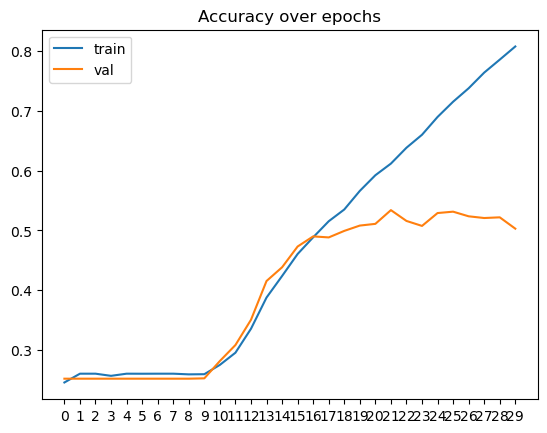

In [20]:
plt.plot(base_history.history["accuracy"], label="train")
plt.plot(base_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

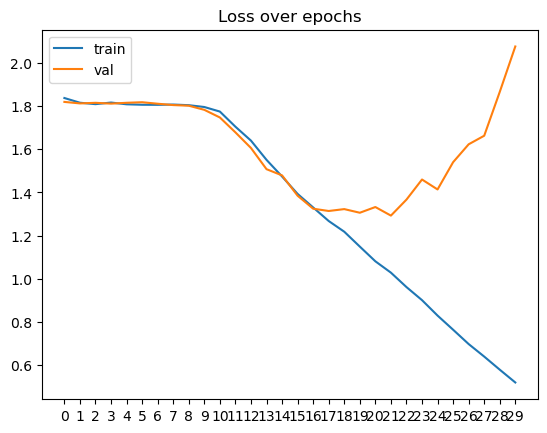

In [21]:
plt.plot(base_history.history["loss"], label="train")
plt.plot(base_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Improving the model

In [22]:
def build_model(learning_rate=0.001, dense_layer_units=[128,64], drop_rate=0):
    input_shape = (48,48,1)
    num_categories = 7 

    base_model = tf.keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),
    
        # First Convolutional Layer (32 filters)
        keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Second Convolutional Layer (64 filters)
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Third Convolutional Layer (128 filters)
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Flatten()
    ])

    # Add additional dense layers
    for unit in dense_layer_units:
        base_model.add(keras.layers.Dense(unit, activation='relu'))
        # Add dropout
        if drop_rate > 0:
            base_model.add(keras.layers.Dropout(drop_rate))
            
    
    # Final output layer
    base_model.add(keras.layers.Dense(num_categories, activation='softmax')) 

    optimizer = keras.optimizers.Adam(learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    
    base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return base_model
    

### 1. Class Imbalance: adjust the loss function

We know we have an imbalanced dataset and we explored methods of rectifying this in the EDA. I will go with the simplest approach for just now: adjusting the loss function so that under-represented classes have larger weight when the loss function is calculated. I can achieve this by passing in a class_weight dictionary. 

In [31]:
def calculate_class_weights(df_meta, label_encoder_for_weights):
    # Sort categories alphabetically and get counts
    category_counts = (
        df_meta["category"]
        .value_counts()
        .reset_index()
        .sort_values(by="category")
        .reset_index(drop=True)
    )
    # Get the index for each category from the label encoder
    category_counts["encoded_index"] = category_counts["category"].apply(
        lambda x: label_encoder_for_weights(x).numpy()
    )

    # Calculate the weights
    category_counts["weights"] = np.sum(category_counts["count"]) / category_counts["count"]
    
    # Normalize the weights
    category_counts["normalized_weights"] = category_counts["weights"] / np.sum(category_counts["weights"])
    
    # Map the encoded index to the weight
    class_weight_dict = dict(zip(category_counts["encoded_index"], category_counts["normalized_weights"]))
    
    return class_weight_dict

In [32]:
class_weight_dict = calculate_class_weights(df_meta_train, label_encoder_for_weights)
class_weight_dict

{5: 0.06450876891812936,
 4: 0.6437004038282156,
 2: 0.06323119889730557,
 6: 0.03441456599943895,
 1: 0.05058228775329451,
 0: 0.05227167653876799,
 3: 0.09129109806484796}

In [33]:
# We use the same model configuration as before
class_weight_model = build_model()

class_weight_history = class_weight_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset,
    class_weight=class_weight_dict # Add Class Weights
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1877 - loss: 0.1256 - val_accuracy: 0.1820 - val_loss: 1.8978
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1131 - loss: 0.1301 - val_accuracy: 0.2519 - val_loss: 1.9295
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1228 - loss: 0.1124 - val_accuracy: 0.0155 - val_loss: 1.9602
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.0136 - loss: 0.1236 - val_accuracy: 0.0155 - val_loss: 1.9590
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0142 - loss: 0.1217 - val_accuracy: 0.0155 - val_loss: 1.9564
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0125 - loss: 0.1197 - val_accuracy: 0.0155 - val_loss: 1.9550
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0699 - loss: 0.1235 - val_accuracy: 0.0155 - val_loss: 1.9541
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0270 - loss: 0.1238 - val_accuracy: 

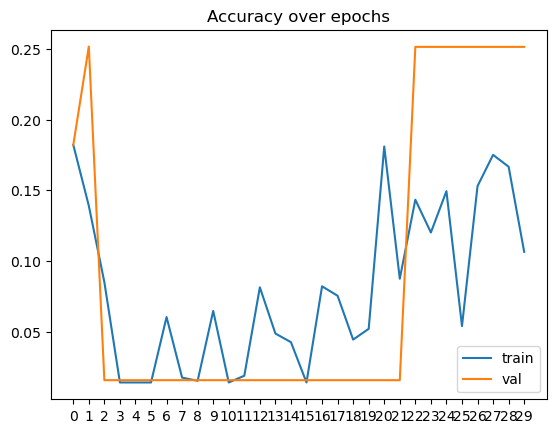

In [34]:
plt.plot(class_weight_history.history["accuracy"], label="train")
plt.plot(class_weight_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

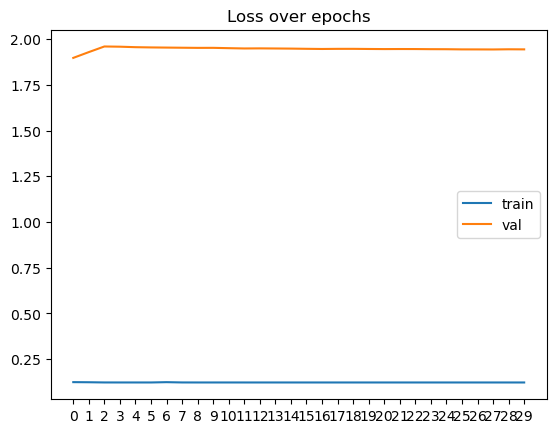

In [35]:
plt.plot(class_weight_history.history["loss"], label="train")
plt.plot(class_weight_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**

These results are much worse. We have a much higher weight for category 4 ("disgust") than the other categories and it looks like our model is really struggling. 

Before giving up on this approach, I will try to reduce the weight of category 4.



In [38]:
updated_class_weight_dict = {5: 0.06,
 4: 0.1, # reduce this from 0.6 to 0.1
 2: 0.06,
 6: 0.03,
 1: 0.05,
 0: 0.05,
 3: 0.09}

In [39]:
# We use the same model configuration as before
class_weight_model = build_model()

class_weight_history = class_weight_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset,
    class_weight=updated_class_weight_dict # Updated Class Weights
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1799 - loss: 0.1006 - val_accuracy: 0.1694 - val_loss: 1.8614
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1485 - loss: 0.0990 - val_accuracy: 0.1694 - val_loss: 1.8599
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1375 - loss: 0.0988 - val_accuracy: 0.1694 - val_loss: 1.8583
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1304 - loss: 0.0987 - val_accuracy: 0.1694 - val_loss: 1.8584
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1834 - loss: 0.0977 - val_accuracy: 0.1386 - val_loss: 1.8577
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1299 - loss: 0.0983 - val_accuracy: 0.1694 - val_loss: 1.8597
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1600 - loss: 0.0984 - val_accuracy: 0.1285 - val_loss: 1.8583
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1701 - loss: 0.0969 - val_accuracy: 0

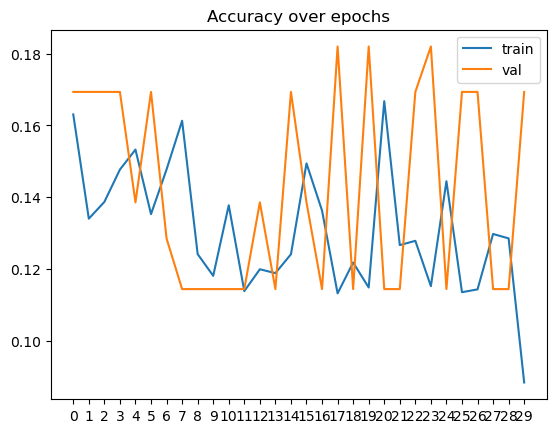

In [40]:
plt.plot(class_weight_history.history["accuracy"], label="train")
plt.plot(class_weight_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

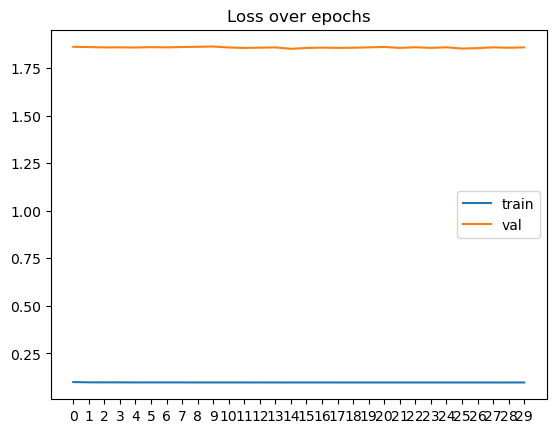

In [41]:
plt.plot(class_weight_history.history["loss"], label="train")
plt.plot(class_weight_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**

These results are even worse! I will dispense with the class weights for just now and try to improve the model in other ways.

### 2. Data Augmentation

I have added an additional function to our dataset creator that will augment images. I have chosen the same settings used in the EDA.

I apply transformations to the training dataset but NOT the validation dataset. When we use this in the training dataset, changes are applied randomly but we do not want randomness in our validation dataset: we want the same dataset to be evaluated against each model so we do not change this.

**Next steps: Additional Epochs**

Given the previous results, I will increase the number of epochs of training from 30 to 50 to see if the accuracy improves with more time.

In [42]:
# We use the same model configuration as before
data_aug_model = build_model()

# We now add augmentation to our training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

# Augmentation ddoes not change the number of images just 
expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

In [43]:
data_aug_history = data_aug_model.fit(
    train_dataset,          
    epochs=50,           
    validation_data=val_dataset
)

Epoch 1/50


2025-01-27 14:15:14.440782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 422 of 1000
2025-01-27 14:15:24.173331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.2204 - loss: 1.8879 - val_accuracy: 0.2516 - val_loss: 1.8150
Epoch 2/50


2025-01-27 14:15:40.348696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 414 of 1000


 31/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1955 - loss: 1.7752       

2025-01-27 14:15:50.356314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 834 of 1000
2025-01-27 14:15:50.415008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2656 - loss: 1.8064 - val_accuracy: 0.2516 - val_loss: 1.8216
Epoch 3/50


2025-01-27 14:16:03.815971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 429 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1921 - loss: 1.9324

2025-01-27 14:16:13.299606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2439 - loss: 1.8314 - val_accuracy: 0.1694 - val_loss: 1.9986
Epoch 4/50


2025-01-27 14:16:26.729928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 406 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0633 - loss: 1.9438

2025-01-27 14:16:37.277025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2187 - loss: 1.8408 - val_accuracy: 0.2516 - val_loss: 1.8101
Epoch 5/50


2025-01-27 14:16:50.686271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 422 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3559 - loss: 1.7044

2025-01-27 14:17:00.439733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2650 - loss: 1.7956 - val_accuracy: 0.2516 - val_loss: 1.8125
Epoch 6/50


2025-01-27 14:17:13.831289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 422 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2002 - loss: 1.7599

2025-01-27 14:17:23.576418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2368 - loss: 1.7998 - val_accuracy: 0.2516 - val_loss: 1.8142
Epoch 7/50


2025-01-27 14:17:36.977722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-27 14:17:46.979966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 823 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2092 - loss: 1.7593

2025-01-27 14:17:47.311562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2496 - loss: 1.8007 - val_accuracy: 0.2516 - val_loss: 1.8158
Epoch 8/50


2025-01-27 14:18:00.710571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 421 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1690 - loss: 1.8200

2025-01-27 14:18:10.614325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2686 - loss: 1.7931 - val_accuracy: 0.2516 - val_loss: 1.8066
Epoch 9/50


2025-01-27 14:18:24.005501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3017 - loss: 1.7359

2025-01-27 14:18:33.927405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2579 - loss: 1.7982 - val_accuracy: 0.2516 - val_loss: 1.8061
Epoch 10/50


2025-01-27 14:18:47.346391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 403 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0946 - loss: 1.8139

2025-01-27 14:18:58.057748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2425 - loss: 1.7996 - val_accuracy: 0.2516 - val_loss: 1.7987
Epoch 11/50


2025-01-27 14:19:11.449111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 415 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3569 - loss: 1.7405

2025-01-27 14:19:21.435603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2603 - loss: 1.7656 - val_accuracy: 0.2513 - val_loss: 1.7927
Epoch 12/50


2025-01-27 14:19:34.838392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2435 - loss: 1.8341

2025-01-27 14:19:44.618038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2663 - loss: 1.7848 - val_accuracy: 0.2858 - val_loss: 1.7396
Epoch 13/50


2025-01-27 14:19:57.994034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-27 14:20:07.997157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 824 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1916 - loss: 1.7042

2025-01-27 14:20:08.306154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2789 - loss: 1.7388 - val_accuracy: 0.3209 - val_loss: 1.6998
Epoch 14/50


2025-01-27 14:20:21.712434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 413 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2617 - loss: 1.7595

2025-01-27 14:20:31.923244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2819 - loss: 1.7286 - val_accuracy: 0.3493 - val_loss: 1.6517
Epoch 15/50


2025-01-27 14:21:02.660820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 427 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3586 - loss: 1.5709

2025-01-27 14:21:12.291765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.3162 - loss: 1.6882 - val_accuracy: 0.3758 - val_loss: 1.6193
Epoch 16/50


2025-01-27 14:21:25.700839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 414 of 1000


 16/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3853 - loss: 1.5774     

2025-01-27 14:21:35.708029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 832 of 1000
2025-01-27 14:21:35.813385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3328 - loss: 1.6634 - val_accuracy: 0.3545 - val_loss: 1.5914
Epoch 17/50


2025-01-27 14:21:49.240289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3840 - loss: 1.6239

2025-01-27 14:21:59.155579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3581 - loss: 1.6254 - val_accuracy: 0.3594 - val_loss: 1.5804
Epoch 18/50


2025-01-27 14:22:12.538048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 426 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3964 - loss: 1.5471

2025-01-27 14:22:22.108547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3697 - loss: 1.5799 - val_accuracy: 0.3951 - val_loss: 1.5330
Epoch 19/50


2025-01-27 14:22:35.533131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 430 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3960 - loss: 1.4893

2025-01-27 14:22:45.043599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3866 - loss: 1.5538 - val_accuracy: 0.3942 - val_loss: 1.5077
Epoch 20/50


2025-01-27 14:22:58.452674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 413 of 1000


  1/837 ━━━━━━━━━━━━━━━━━━━━ 4:41:08 20s/step - accuracy: 0.7500 - loss: 0.8994

2025-01-27 14:23:08.462538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 830 of 1000
2025-01-27 14:23:08.614545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4114 - loss: 1.5177 - val_accuracy: 0.3856 - val_loss: 1.5933
Epoch 21/50


2025-01-27 14:23:21.991763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 424 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3485 - loss: 1.6969

2025-01-27 14:23:31.658872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4091 - loss: 1.5181 - val_accuracy: 0.4307 - val_loss: 1.4636
Epoch 22/50


2025-01-27 14:23:45.062744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 414 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3406 - loss: 1.5909

2025-01-27 14:23:55.193203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4063 - loss: 1.4946 - val_accuracy: 0.4626 - val_loss: 1.4007
Epoch 23/50


2025-01-27 14:24:08.614401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 406 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4528 - loss: 1.4068

2025-01-27 14:24:19.193110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4245 - loss: 1.4755 - val_accuracy: 0.4609 - val_loss: 1.4017
Epoch 24/50


2025-01-27 14:24:32.609117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 426 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4304 - loss: 1.3867

2025-01-27 14:24:42.252453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4399 - loss: 1.4239 - val_accuracy: 0.4666 - val_loss: 1.3926
Epoch 25/50


2025-01-27 14:24:55.713840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5385 - loss: 1.2608

2025-01-27 14:25:05.463791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4584 - loss: 1.4115 - val_accuracy: 0.4730 - val_loss: 1.3747
Epoch 26/50


2025-01-27 14:25:18.910541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 398 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4320 - loss: 1.4310

2025-01-27 14:25:29.809853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4522 - loss: 1.3936 - val_accuracy: 0.4646 - val_loss: 1.3962
Epoch 27/50


2025-01-27 14:25:43.229263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 421 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3635 - loss: 1.5447

2025-01-27 14:25:53.041748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4488 - loss: 1.4033 - val_accuracy: 0.4710 - val_loss: 1.3642
Epoch 28/50


2025-01-27 14:26:06.481073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 426 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4545 - loss: 1.3524

2025-01-27 14:26:16.127079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4624 - loss: 1.3757 - val_accuracy: 0.4836 - val_loss: 1.3328
Epoch 29/50


2025-01-27 14:26:29.540184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 411 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4734 - loss: 1.3444

2025-01-27 14:26:39.800437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4715 - loss: 1.3677 - val_accuracy: 0.4750 - val_loss: 1.3458
Epoch 30/50


2025-01-27 14:26:53.197647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4519 - loss: 1.4996

2025-01-27 14:27:03.027797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4624 - loss: 1.3976 - val_accuracy: 0.4911 - val_loss: 1.3175
Epoch 31/50


2025-01-27 14:27:16.433987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 424 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4359 - loss: 1.3979

2025-01-27 14:27:26.088399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4710 - loss: 1.3524 - val_accuracy: 0.4868 - val_loss: 1.3191
Epoch 32/50


2025-01-27 14:27:39.520744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4538 - loss: 1.3329

2025-01-27 14:27:49.504769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4821 - loss: 1.3324 - val_accuracy: 0.4919 - val_loss: 1.3203
Epoch 33/50


2025-01-27 14:28:02.909211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 420 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4787 - loss: 1.4296

2025-01-27 14:28:12.797580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4764 - loss: 1.3588 - val_accuracy: 0.4853 - val_loss: 1.3253
Epoch 34/50


2025-01-27 14:28:26.224911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 416 of 1000


 31/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4874 - loss: 1.2935   

2025-01-27 14:28:36.227739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 834 of 1000
2025-01-27 14:28:36.285158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4680 - loss: 1.3529 - val_accuracy: 0.4997 - val_loss: 1.3080
Epoch 35/50


2025-01-27 14:28:49.713150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4462 - loss: 1.4766

2025-01-27 14:28:59.675252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4843 - loss: 1.3433 - val_accuracy: 0.4983 - val_loss: 1.2882
Epoch 36/50


2025-01-27 14:29:13.079162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4954 - loss: 1.2669

2025-01-27 14:29:23.450818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4988 - loss: 1.3002 - val_accuracy: 0.4825 - val_loss: 1.3269
Epoch 37/50


2025-01-27 14:29:36.853380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 426 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5181 - loss: 1.2103

2025-01-27 14:29:46.429759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4915 - loss: 1.3063 - val_accuracy: 0.4868 - val_loss: 1.3061
Epoch 38/50


2025-01-27 14:29:59.840133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4535 - loss: 1.3578

2025-01-27 14:30:09.808580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4948 - loss: 1.3123 - val_accuracy: 0.5124 - val_loss: 1.2655
Epoch 39/50


2025-01-27 14:30:40.783524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 406 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4893 - loss: 1.3375

2025-01-27 14:30:51.328194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.4924 - loss: 1.2989 - val_accuracy: 0.5216 - val_loss: 1.2540
Epoch 40/50


2025-01-27 14:31:04.761761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4554 - loss: 1.3460

2025-01-27 14:31:14.504668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5091 - loss: 1.2743 - val_accuracy: 0.5092 - val_loss: 1.2659
Epoch 41/50


2025-01-27 14:31:27.892747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 422 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4957 - loss: 1.2670

2025-01-27 14:31:37.642155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4965 - loss: 1.2985 - val_accuracy: 0.4779 - val_loss: 1.3524
Epoch 42/50


2025-01-27 14:31:51.065200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-27 14:32:01.066795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 821 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5186 - loss: 1.2648

2025-01-27 14:32:01.435675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5039 - loss: 1.2794 - val_accuracy: 0.5112 - val_loss: 1.2715
Epoch 43/50


2025-01-27 14:32:14.861380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5554 - loss: 1.1446

2025-01-27 14:32:24.516073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5181 - loss: 1.2465 - val_accuracy: 0.5020 - val_loss: 1.3012
Epoch 44/50


2025-01-27 14:32:37.918031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 429 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5085 - loss: 1.3765

2025-01-27 14:32:47.385396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5154 - loss: 1.2726 - val_accuracy: 0.4931 - val_loss: 1.3112
Epoch 45/50


2025-01-27 14:33:00.809282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 424 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4393 - loss: 1.4387

2025-01-27 14:33:10.510850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4957 - loss: 1.2943 - val_accuracy: 0.5138 - val_loss: 1.2721
Epoch 46/50


2025-01-27 14:33:23.910140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5088 - loss: 1.3178

2025-01-27 14:33:33.666530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5116 - loss: 1.2646 - val_accuracy: 0.5173 - val_loss: 1.2482
Epoch 47/50


2025-01-27 14:33:47.087684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 414 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5407 - loss: 1.1907

2025-01-27 14:33:57.160585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5099 - loss: 1.2618 - val_accuracy: 0.5267 - val_loss: 1.2574
Epoch 48/50


2025-01-27 14:34:10.559694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 421 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5488 - loss: 1.1779

2025-01-27 14:34:20.302827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5248 - loss: 1.2466 - val_accuracy: 0.5127 - val_loss: 1.2936
Epoch 49/50


2025-01-27 14:34:33.718107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 424 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4356 - loss: 1.3477

2025-01-27 14:34:43.346326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5099 - loss: 1.2593 - val_accuracy: 0.5193 - val_loss: 1.2724
Epoch 50/50


2025-01-27 14:34:56.771740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 420 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4715 - loss: 1.3233

2025-01-27 14:35:06.577489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5202 - loss: 1.2497 - val_accuracy: 0.5072 - val_loss: 1.2695


In [49]:
def get_best_accuracy(hist):
    best_accuracy = 0
    best_epoch = 0
    for idx, acc in enumerate(hist.history["val_accuracy"]):
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = idx
    return best_accuracy, best_epoch

def get_lowest_loss(hist):
    lowest_loss = hist.history["val_loss"][0]
    loss_epoch = 0
    for idx, loss in enumerate(hist.history["val_loss"]):
        if loss < lowest_loss:
            lowest_loss = loss
            loss_epoch = idx
    return lowest_loss, loss_epoch

In [48]:
get_best_accuracy(data_aug_history)

(0.5267394781112671, 46)

In [50]:
get_lowest_loss(data_aug_history)

(1.2481513023376465, 45)

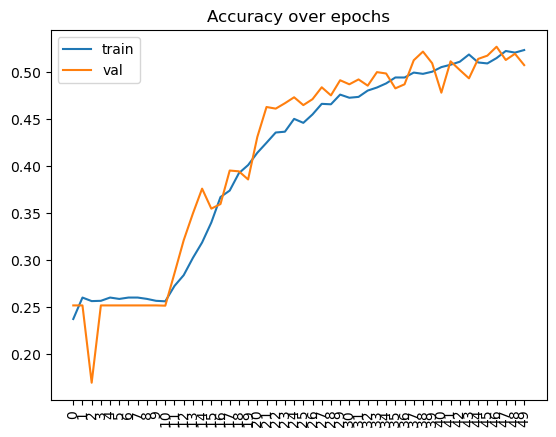

In [44]:
plt.plot(data_aug_history.history["accuracy"], label="train")
plt.plot(data_aug_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(50), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

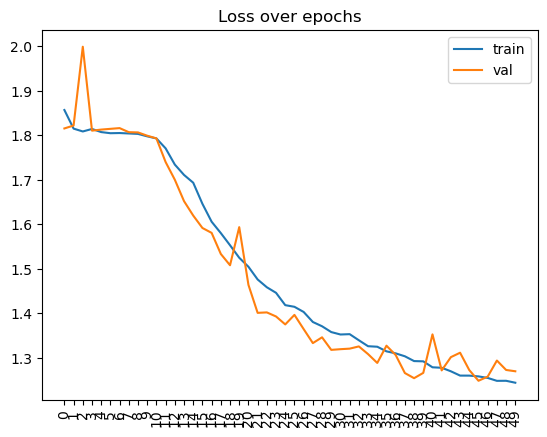

In [45]:
plt.plot(data_aug_history.history["loss"], label="train")
plt.plot(data_aug_history.history["val_loss"], label="val")
plt.xticks(np.arange(50), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**

I applied 4 different types of augmentation and training set accuracy struggled to improve within the number of epochs. 

The validation set failed to get an accuracy of higher than 0.526. And you can see that the training set is having similar difficulties. On a plus point at least there is no overfitting! 

Is there a problem with our augmentation? We are already dealing with very small images and it's possible that the augmentation is too much. Then again, the steady increase in accuracy in both sets suggests that the model is learning and perhaps more effectively.

Does the model just need more time? This is a possible conclusion since both loss and accuracy are improving.

**Next Steps**

I want to experiment with other changes and augmenting the images and training the model over more epochs takes time.

- augmentation: Before training the final model, I will try training the model with augmented images and compare but for now, to save time, I will not augment the images.
- epochs: I will limit the epochs to 30 to save time

### 3. Modifying the Learning Rate

The default learning rate is `0.001`. We can experiment to see if a slower or faster learning rate works better for this model.

In [51]:
# Do not augment the images to save time
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

lr_scores = {}

for lr in [0.0001,0.001,0.01,0.1]:
    print(lr)
    
    model = build_model(learning_rate=lr)

    history = model.fit(
        train_dataset,          
        epochs=30,  # Keep epochs to 30         
        validation_data=val_dataset
    )
    lr_scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2184 - loss: 1.8668 - val_accuracy: 0.2516 - val_loss: 1.8273
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2367 - loss: 1.8189 - val_accuracy: 0.2519 - val_loss: 1.8646
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2700 - loss: 1.7707 - val_accuracy: 0.3039 - val_loss: 1.7606
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2989 - loss: 1.7488 - val_accuracy: 0.3275 - val_loss: 1.7036
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3214 - loss: 1.6859 - val_accuracy: 0.3666 - val_loss: 1.6315
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3683 - loss: 1.6239 - val_accuracy: 0.3930 - val_loss: 1.5883
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3823 - loss: 1.5975 - val_accuracy: 0.4112 - val_loss: 1.5611
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3992 - loss: 1.5446 - val_accu

In [62]:
for lr, hist in lr_scores.items():
    print(f"{lr} best accuracy: {np.max(hist["val_accuracy"])}")

0.0001 best accuracy: 0.5215641260147095
0.001 best accuracy: 0.5186889171600342
0.01 best accuracy: 0.2515813708305359
0.1 best accuracy: 0.2515813708305359


In [63]:
for lr, hist in lr_scores.items():
    print(f"{lr} lowest loss: {np.max(hist["val_loss"])}")

0.0001 lowest loss: 1.8646221160888672
0.001 lowest loss: 1.8182458877563477
0.01 lowest loss: 1.8199070692062378
0.1 lowest loss: 1.9538695812225342


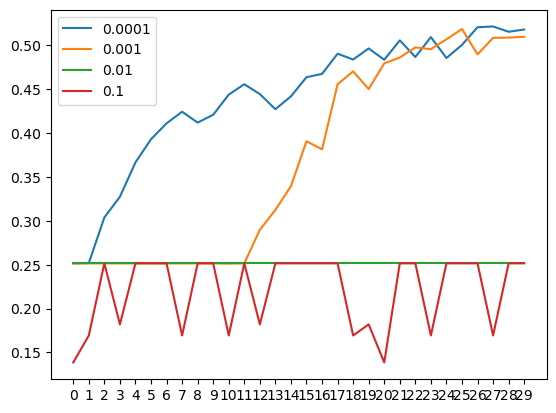

In [52]:
for lr, hist in lr_scores.items():
    plt.plot(hist["val_accuracy"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

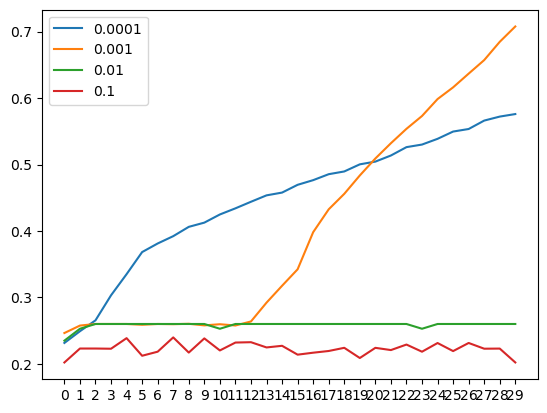

In [53]:
for lr, hist in lr_scores.items():
    plt.plot(hist["accuracy"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

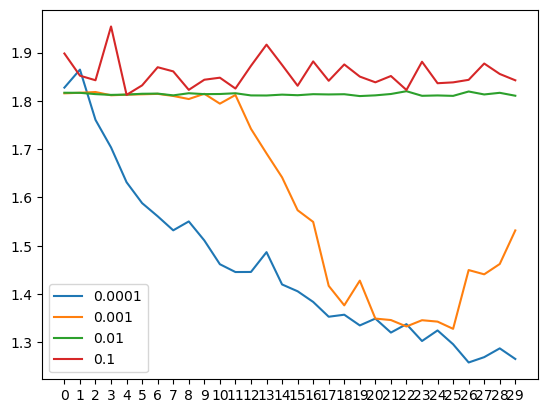

In [54]:
for lr, hist in lr_scores.items():
    plt.plot(hist["val_loss"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**

It looks like the higher learning rates (0.01 and 0.1) are too much for this dataset. The best accuracy we get is with the lowest learning rate (0.52). The training set is struggling to get much better. I'm curious to see how the lower training rate might do if we train the model for more epochs. 

**Next steps**

I will use the lower learning rate and later see if training for longer improves our model.

- learning_rate = 0.0001

### 4. Modifying the Dense layers

More layers means more complexity. Our base model has 2 dense layers, excluding the output layer.

If the model is underfitting, it means that it is not capturing enough patterns and so adding additional dense layers may prove helpful.

If the model is overfitting and performing too well on training data but badly on new data then removing layers can simplify the model and improve generalization.

We will try a few permutations, ranging from removing the 2 additional layers entirely to adding an extra one.

In [72]:
# We will not augment the images for just now
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)


learning_rate=0.0001
dlu_scores = {}

dlu_array = [[],[32],[64,32],[128,64],[128,64,32]]

for idx, dlu in enumerate(dlu_array):
    print(dlu)
    
    model = build_model(learning_rate=learning_rate,dense_layer_units=dlu)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset
    )
    dlu_scores[idx] = history.history

    print()
    print()

[]
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2384 - loss: 1.8595 - val_accuracy: 0.2516 - val_loss: 1.8175
Epoch 2/30
827/837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2671 - loss: 1.8139

KeyboardInterrupt: 

In [70]:
for dlu, hist in dlu_scores.items():
    print(f"{dlu_array[dlu]} best accuracy: {np.max(hist["val_accuracy"])}")

[] best accuracy: 0.5120759010314941
[32] best accuracy: 0.49597468972206116
[64, 32] best accuracy: 0.4945370852947235
[128, 64] best accuracy: 0.5373777747154236
[128, 64, 32] best accuracy: 0.5327774286270142


In [71]:
for dlu, hist in dlu_scores.items():
    print(f"{dlu_array[dlu]} lowest loss: {np.max(hist["val_loss"])}")

[] lowest loss: 1.8226500749588013
[32] lowest loss: 1.8268316984176636
[64, 32] lowest loss: 1.8671627044677734
[128, 64] lowest loss: 1.817812442779541
[128, 64, 32] lowest loss: 1.833196759223938


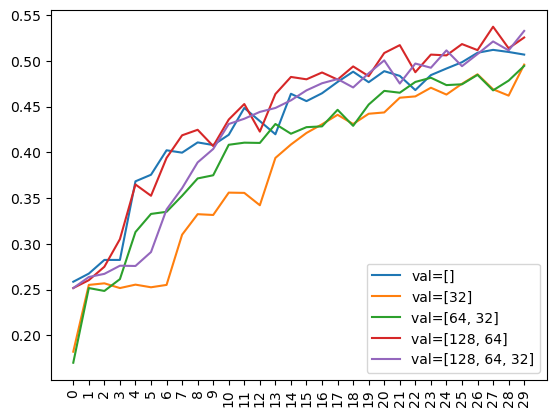

In [65]:
for idx_dlu, hist in dlu_scores.items():
    plt.plot(hist["val_accuracy"], label=(f'val={dlu_array[idx_dlu]}'))
plt.xticks(np.arange(30), rotation=90)
plt.legend()
plt.show()

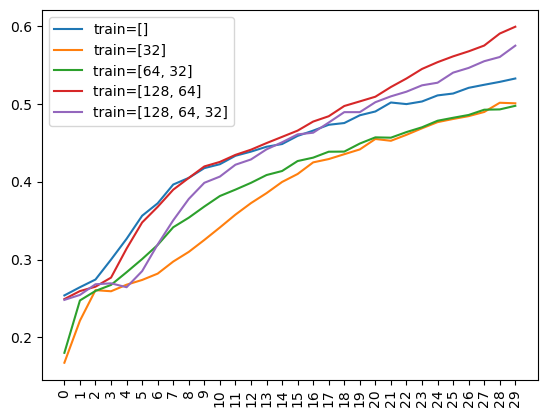

In [66]:
for idx_dlu, hist in dlu_scores.items():
    plt.plot(hist["accuracy"], label=(f'train={dlu_array[idx_dlu]}'))
plt.xticks(np.arange(30), rotation=90)
plt.legend()
plt.show()

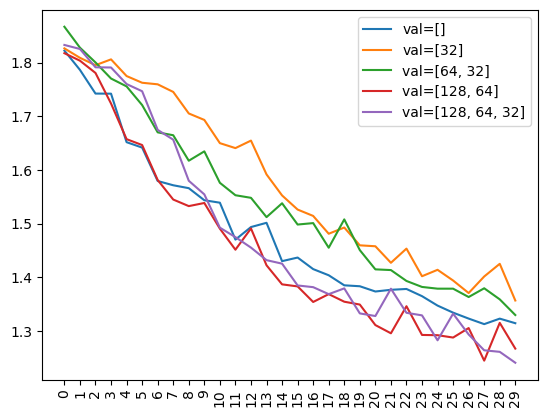

In [67]:
for idx_dlu, hist in dlu_scores.items():
    plt.plot(hist["val_loss"], label=(f'val={dlu_array[idx_dlu]}'))
plt.xticks(np.arange(30), rotation=90)
plt.legend()
plt.show()

**Evaluation**

Our original model was built with 2 additional dense layers of size 128 and 64. The results above suggest this was a good choice as it performs better having lower loss and higher accuracy than the simpler models.

It might even be a good idea to use the more complex one especially if we train it for longer.

**Next Steps**

Maintain the current 

- dense_layer_units = [128,64]

### 5. Regularization via Dropout

Dropout is a way of regularizing our neural net. We want to reduce the liklihood that our model will learn an irrelevant rule. Dropout forces the model to focus on the bigger picture and can prevent overfitting.

During training we randomly drop or deactive a certain percentage of neurons in a layer which temporarily makes them inactive in that training step which means their outputs don't contribute to the forward pass or the gradient updates during back propagation. When neurons are dropped randomly, the network can't rely on a given neuron, which prevents overfitting.

In [73]:
# Do not augment images in training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

learning_rate=0.0001
dense_layer_units = [128,64]

dr_scores = {}

for dr in [0.0,0.2,0.5,0.8]:
    print(dr)
    
    model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=dr)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset
    )
    dr_scores[dr] = history.history

    print()
    print()

0.0
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2652 - loss: 1.8430 - val_accuracy: 0.2516 - val_loss: 1.8323
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2115 - loss: 1.8234 - val_accuracy: 0.2562 - val_loss: 1.8101
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2597 - loss: 1.8043 - val_accuracy: 0.3148 - val_loss: 1.7364
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2764 - loss: 1.7277 - val_accuracy: 0.3468 - val_loss: 1.6670
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3188 - loss: 1.6963 - val_accuracy: 0.3551 - val_loss: 1.6828
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3459 - loss: 1.6513 - val_accuracy: 0.3899 - val_loss: 1.5961
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3780 - loss: 1.6021 - val_accuracy: 0.3994 - val_loss: 1.5707
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3870 - loss: 1.5806 - val_accurac

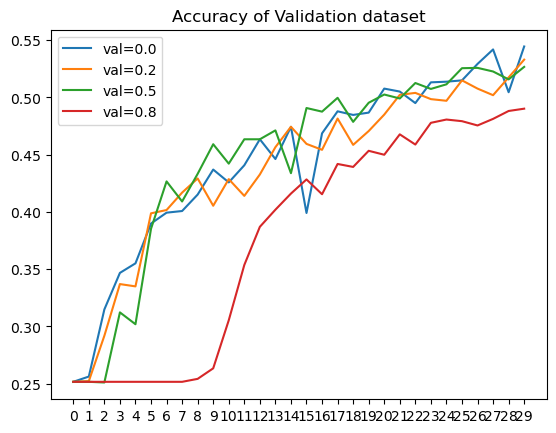

In [74]:
for dr, hist in dr_scores.items():
    #plt.plot(hist["accuracy"], label=(f'train={dr}'))
    plt.plot(hist["val_accuracy"], label=(f'val={dr}'))
plt.xticks(np.arange(30))
#plt.yticks([0.78,0.80,0.82,0.825,0.83])
plt.legend()
plt.title("Accuracy of Validation dataset")
plt.show()

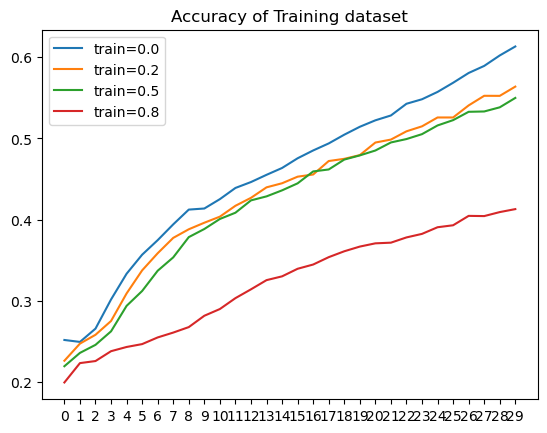

In [75]:
for dr, hist in dr_scores.items():
    plt.plot(hist["accuracy"], label=(f'train={dr}'))
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy of Training dataset")
plt.show()

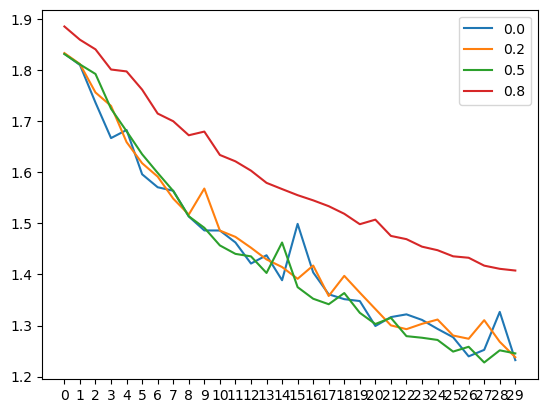

In [76]:
for dr, hist in dr_scores.items():
    plt.plot(hist["val_loss"], label=dr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**

We don't really have an overfitting issue in our model so it is perhaps not surprising that adding dropout doesn't improve scores. For just now, we will stick with a drop_rate of zero.

**Next steps**
Do not add regularization.

- drop_rate =0.0

## Building our Final Model

Unfortunately the model has not improved much with tweaks. Given that the training dataset accuracy and validation dataset accuracy appears to be increasing at the final epoch I have tested at (and the loss decreasing), I am hopeful that by increasing the number of epochs, allowing the model to train for longer, I will get better results.

For that reason, the final model will be trained for 100 epochs.

In [77]:
# Do not use augmentation
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

learning_rate=0.0001
dense_layer_units = [128,64]
drop_rate = 0.0

final_model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=drop_rate)

checkpoint = keras.callbacks.ModelCheckpoint('data/er_final_{epoch:02d}_{val_accuracy:.3f}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                               )

final_history = final_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[checkpoint])

Epoch 1/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2447 - loss: 1.8564 - val_accuracy: 0.1694 - val_loss: 1.8363
Epoch 2/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2543 - loss: 1.8305 - val_accuracy: 0.2570 - val_loss: 1.8455
Epoch 3/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2928 - loss: 1.7693 - val_accuracy: 0.2760 - val_loss: 1.7687
Epoch 4/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2820 - loss: 1.7767 - val_accuracy: 0.2976 - val_loss: 1.7267
Epoch 5/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3135 - loss: 1.7290 - val_accuracy: 0.3269 - val_loss: 1.6813
Epoch 6/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3445 - loss: 1.6590 - val_accuracy: 0.3752 - val_loss: 1.6399
Epoch 7/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3563 - loss: 1.6461 - val_accuracy: 0.3942 - val_loss: 1.6008
Epoch 8/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3800 - loss: 1.5990 - val_acc

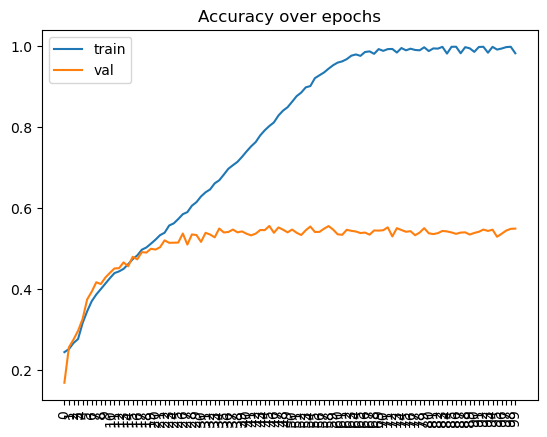

In [78]:
plt.plot(final_history.history["accuracy"], label="train")
plt.plot(final_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(100), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

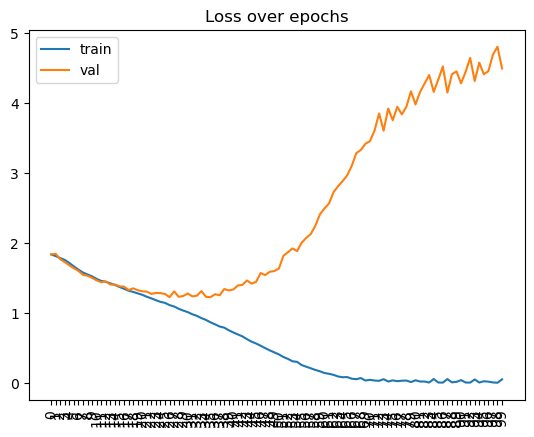

In [79]:
plt.plot(final_history.history["loss"], label="train")
plt.plot(final_history.history["val_loss"], label="val")
plt.xticks(np.arange(100), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [80]:
get_best_accuracy(final_history)

(0.5566417574882507, 45)

In [81]:
get_lowest_loss(final_history)

(1.226230502128601, 26)

**Evaluate**

Unfortunately training for longer improved the accuracy somewhat but not as much as we'd hoped.

Our best model was achieved after 45 epochs and got a score on the validation set of 0.556. This model is still better than our base model, however.

Perhaps, given that it is now starting to show signs of overfitting it would benefit from regularization.

### Final model with dropout

In [82]:
# Do not use augmentation
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

learning_rate=0.0001
dense_layer_units = [128,64]
drop_rate = 0.2

final_model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=drop_rate)

checkpoint = keras.callbacks.ModelCheckpoint('data/er_final_with_dr_{epoch:02d}_{val_accuracy:.3f}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                               )

final_history = final_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[checkpoint])

Epoch 1/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2156 - loss: 1.8790 - val_accuracy: 0.2516 - val_loss: 1.8324
Epoch 2/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2499 - loss: 1.8196 - val_accuracy: 0.2533 - val_loss: 1.8136
Epoch 3/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2754 - loss: 1.8094 - val_accuracy: 0.2579 - val_loss: 1.7863
Epoch 4/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2564 - loss: 1.8077 - val_accuracy: 0.2872 - val_loss: 1.7512
Epoch 5/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2922 - loss: 1.7481 - val_accuracy: 0.3649 - val_loss: 1.6898
Epoch 6/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3112 - loss: 1.7049 - val_accuracy: 0.3548 - val_loss: 1.6773
Epoch 7/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3399 - loss: 1.6788 - val_accuracy: 0.4005 - val_loss: 1.6106
Epoch 8/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3620 - loss: 1.6236 - val_acc

In [83]:
get_best_accuracy(final_history)

(0.5828062295913696, 69)

In [84]:
get_lowest_loss(final_history)

(1.1739169359207153, 39)

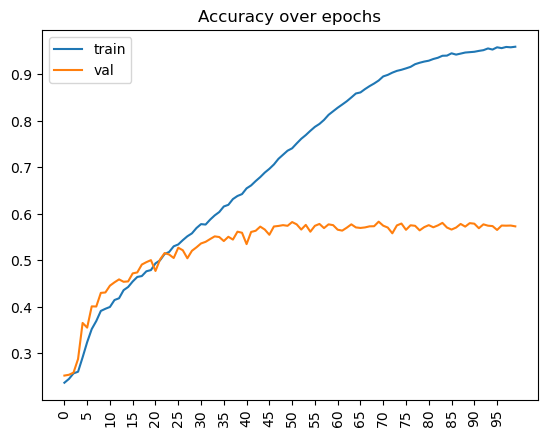

In [91]:
plt.plot(final_history.history["accuracy"], label="train")
plt.plot(final_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(0,100,5), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

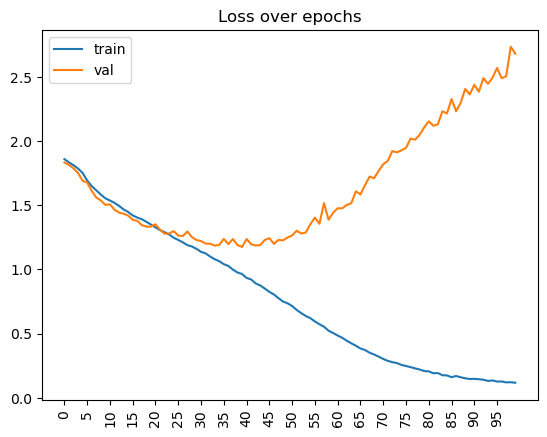

In [90]:
plt.plot(final_history.history["loss"], label="train")
plt.plot(final_history.history["val_loss"], label="val")
plt.xticks(np.arange(0,100,5), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**

With regularization, we are able to improve our accuracy to a high of 0.583 reached after 69 epochs. We can see from the graphs, however, that at this stage the model is starting to fit and the accuracy isn't improving much. Also the loss function is starting to climb. The next best model has an accuracy of 0.582 reached after 51 epochs before there are signs of overfitting. It might be better to choose this one.

### Another model with augmentation

We saw that the training model accuracy was slow to converge with augmentation, perhaps if we train a model with augmented data for longer we will get better results.

I am going to train this model for 150 epochs and see if it can improve on our last model. I will not use dropout since we saw that this model was slow to converge previously.

In [92]:
# Use
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

learning_rate=0.0001
dense_layer_units = [128,64]
drop_rate = 0.0

final_with_aug_model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=drop_rate)

checkpoint = keras.callbacks.ModelCheckpoint('er_final_with_aug_{epoch:02d}_{val_accuracy:.3f}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                               )

final_with_aug_history = final_with_aug_model.fit(train_dataset, epochs=150, validation_data=val_dataset, callbacks=[checkpoint])

Epoch 1/150


2025-01-27 16:27:32.936770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-01-27 16:27:42.951165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 825 of 1000
2025-01-27 16:27:43.218929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.2392 - loss: 1.8819 - val_accuracy: 0.2516 - val_loss: 1.8241
Epoch 2/150


2025-01-27 16:27:59.054956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 412 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1087 - loss: 1.8862

2025-01-27 16:28:09.244185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2313 - loss: 1.8348 - val_accuracy: 0.2033 - val_loss: 1.8869
Epoch 3/150


2025-01-27 16:28:22.674032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2714 - loss: 1.8215

2025-01-27 16:28:32.722995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2416 - loss: 1.8139 - val_accuracy: 0.2608 - val_loss: 1.8032
Epoch 4/150


2025-01-27 16:28:46.289790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 415 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1844 - loss: 1.8790

2025-01-27 16:28:56.336598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2466 - loss: 1.7969 - val_accuracy: 0.2740 - val_loss: 1.7643
Epoch 5/150


2025-01-27 16:29:09.845248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1825 - loss: 1.8585

2025-01-27 16:29:19.698175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2712 - loss: 1.7571 - val_accuracy: 0.2907 - val_loss: 1.7383
Epoch 6/150


2025-01-27 16:29:33.252098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 425 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2037 - loss: 1.9926

2025-01-27 16:29:42.949280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.2750 - loss: 1.7620 - val_accuracy: 0.3427 - val_loss: 1.6993
Epoch 7/150


2025-01-27 16:29:56.493586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 405 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4379 - loss: 1.5893

2025-01-27 16:30:07.048084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2992 - loss: 1.7218 - val_accuracy: 0.3516 - val_loss: 1.6678
Epoch 8/150


2025-01-27 16:30:37.425853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 413 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3466 - loss: 1.6400

2025-01-27 16:30:47.594873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.3204 - loss: 1.7119 - val_accuracy: 0.3539 - val_loss: 1.6487
Epoch 9/150


2025-01-27 16:31:01.103180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2865 - loss: 1.8191

2025-01-27 16:31:11.077808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3354 - loss: 1.7057 - val_accuracy: 0.3836 - val_loss: 1.6194
Epoch 10/150


2025-01-27 16:31:24.620990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3664 - loss: 1.6837

2025-01-27 16:31:34.923322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3409 - loss: 1.6690 - val_accuracy: 0.3902 - val_loss: 1.6126
Epoch 11/150


2025-01-27 16:31:48.482018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2900 - loss: 1.6857

2025-01-27 16:31:58.469349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3499 - loss: 1.6583 - val_accuracy: 0.3821 - val_loss: 1.6003
Epoch 12/150


2025-01-27 16:32:11.936140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 419 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3224 - loss: 1.7740

2025-01-27 16:32:21.775876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3559 - loss: 1.6530 - val_accuracy: 0.4091 - val_loss: 1.5525
Epoch 13/150


2025-01-27 16:32:35.282263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-27 16:32:45.297218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 819 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4040 - loss: 1.5902

2025-01-27 16:32:45.742148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3635 - loss: 1.6158 - val_accuracy: 0.3838 - val_loss: 1.5854
Epoch 14/150


2025-01-27 16:32:59.211103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4635 - loss: 1.4868

2025-01-27 16:33:09.145242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3870 - loss: 1.5797 - val_accuracy: 0.4086 - val_loss: 1.5382
Epoch 15/150


2025-01-27 16:33:22.576986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4180 - loss: 1.5507

2025-01-27 16:33:32.337684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3860 - loss: 1.5907 - val_accuracy: 0.4008 - val_loss: 1.5372
Epoch 16/150


2025-01-27 16:33:45.828308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 395 of 1000
2025-01-27 16:33:55.834333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 792 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3003 - loss: 1.6860

2025-01-27 16:33:56.933533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.3815 - loss: 1.5710 - val_accuracy: 0.4025 - val_loss: 1.5255
Epoch 17/150


2025-01-27 16:34:10.396964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3858 - loss: 1.5556

2025-01-27 16:34:20.421660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3895 - loss: 1.5649 - val_accuracy: 0.4094 - val_loss: 1.5239
Epoch 18/150


2025-01-27 16:34:33.931705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4166 - loss: 1.5130

2025-01-27 16:34:44.034688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4019 - loss: 1.5410 - val_accuracy: 0.3997 - val_loss: 1.5183
Epoch 19/150


2025-01-27 16:34:57.522914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3181 - loss: 1.6332

2025-01-27 16:35:08.052660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3956 - loss: 1.5461 - val_accuracy: 0.4169 - val_loss: 1.5021
Epoch 20/150


2025-01-27 16:35:21.587623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3730 - loss: 1.5479

2025-01-27 16:35:31.563437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4142 - loss: 1.5041 - val_accuracy: 0.4367 - val_loss: 1.4702
Epoch 21/150


2025-01-27 16:35:45.111777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3941 - loss: 1.5158

2025-01-27 16:35:55.602888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4139 - loss: 1.5062 - val_accuracy: 0.4287 - val_loss: 1.4741
Epoch 22/150


2025-01-27 16:36:09.065798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 415 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3437 - loss: 1.5396

2025-01-27 16:36:19.120518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4097 - loss: 1.5112 - val_accuracy: 0.4339 - val_loss: 1.4581
Epoch 23/150


2025-01-27 16:36:32.560625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 404 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3219 - loss: 1.7164

2025-01-27 16:36:43.185676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3980 - loss: 1.5241 - val_accuracy: 0.4572 - val_loss: 1.4180
Epoch 24/150


2025-01-27 16:36:56.690853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4364 - loss: 1.4997

2025-01-27 16:37:06.554732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4376 - loss: 1.4715 - val_accuracy: 0.4600 - val_loss: 1.4052
Epoch 25/150


2025-01-27 16:37:20.091134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4221 - loss: 1.6801

2025-01-27 16:37:29.779555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4253 - loss: 1.4920 - val_accuracy: 0.4646 - val_loss: 1.4122
Epoch 26/150


2025-01-27 16:37:43.272475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4472 - loss: 1.3895

2025-01-27 16:37:53.285912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 835 of 1000
2025-01-27 16:37:53.319787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4398 - loss: 1.4408 - val_accuracy: 0.4770 - val_loss: 1.3868
Epoch 27/150


2025-01-27 16:38:06.848825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4399 - loss: 1.4656

2025-01-27 16:38:16.832293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4301 - loss: 1.4661 - val_accuracy: 0.4623 - val_loss: 1.3869
Epoch 28/150


2025-01-27 16:38:30.289848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-27 16:38:40.303989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 823 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3646 - loss: 1.6326

2025-01-27 16:38:40.621231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4387 - loss: 1.4649 - val_accuracy: 0.4758 - val_loss: 1.3821
Epoch 29/150


2025-01-27 16:39:11.247602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 403 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5113 - loss: 1.3002

2025-01-27 16:39:21.865110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.4499 - loss: 1.4180 - val_accuracy: 0.4761 - val_loss: 1.3674
Epoch 30/150


2025-01-27 16:39:35.354453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4946 - loss: 1.3966

2025-01-27 16:39:45.252528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4523 - loss: 1.4245 - val_accuracy: 0.4695 - val_loss: 1.3947
Epoch 31/150


2025-01-27 16:39:58.745361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 414 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3810 - loss: 1.4898

2025-01-27 16:40:08.906489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4433 - loss: 1.4174 - val_accuracy: 0.4885 - val_loss: 1.3492
Epoch 32/150


2025-01-27 16:40:22.404704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 404 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4830 - loss: 1.4102

2025-01-27 16:40:33.085588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4692 - loss: 1.3893 - val_accuracy: 0.4902 - val_loss: 1.3531
Epoch 33/150


2025-01-27 16:40:46.605933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-27 16:40:56.615158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 818 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6172 - loss: 1.1476

2025-01-27 16:40:57.081063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4845 - loss: 1.3528 - val_accuracy: 0.4804 - val_loss: 1.3482
Epoch 34/150


2025-01-27 16:41:10.557242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5376 - loss: 1.2525

2025-01-27 16:41:20.378094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4799 - loss: 1.3572 - val_accuracy: 0.4704 - val_loss: 1.3772
Epoch 35/150


2025-01-27 16:41:33.839596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-27 16:41:43.853871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 815 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5049 - loss: 1.3054

2025-01-27 16:41:44.400560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4799 - loss: 1.3661 - val_accuracy: 0.4623 - val_loss: 1.4296
Epoch 36/150


2025-01-27 16:41:57.852384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4226 - loss: 1.4722

2025-01-27 16:42:07.788942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4635 - loss: 1.3947 - val_accuracy: 0.4687 - val_loss: 1.4099
Epoch 37/150


2025-01-27 16:42:21.268630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4345 - loss: 1.4354

2025-01-27 16:42:31.184105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4724 - loss: 1.3606 - val_accuracy: 0.4896 - val_loss: 1.3350
Epoch 38/150


2025-01-27 16:42:44.656441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 423 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5070 - loss: 1.3134

2025-01-27 16:42:54.300329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4707 - loss: 1.3688 - val_accuracy: 0.4776 - val_loss: 1.3472
Epoch 39/150


2025-01-27 16:43:07.751422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 413 of 1000
2025-01-27 16:43:17.756555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 828 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4248 - loss: 1.3714

2025-01-27 16:43:17.959427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4916 - loss: 1.3179 - val_accuracy: 0.4994 - val_loss: 1.3314
Epoch 40/150


2025-01-27 16:43:31.482311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 424 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4486 - loss: 1.4272

2025-01-27 16:43:41.204362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4859 - loss: 1.3433 - val_accuracy: 0.4839 - val_loss: 1.3525
Epoch 41/150


2025-01-27 16:43:54.676382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 422 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4857 - loss: 1.3252

2025-01-27 16:44:04.473525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5011 - loss: 1.2985 - val_accuracy: 0.5009 - val_loss: 1.3024
Epoch 42/150


2025-01-27 16:44:17.987306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-27 16:44:28.005753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 819 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4978 - loss: 1.2704

2025-01-27 16:44:28.453905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5049 - loss: 1.2979 - val_accuracy: 0.4747 - val_loss: 1.3649
Epoch 43/150


2025-01-27 16:44:41.896882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 414 of 1000


 31/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5714 - loss: 1.2197   

2025-01-27 16:44:51.903443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 834 of 1000
2025-01-27 16:44:51.961392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4980 - loss: 1.3154 - val_accuracy: 0.5055 - val_loss: 1.2969
Epoch 44/150


2025-01-27 16:45:05.518746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4924 - loss: 1.2721

2025-01-27 16:45:15.524631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4932 - loss: 1.3176 - val_accuracy: 0.5127 - val_loss: 1.2858
Epoch 45/150


2025-01-27 16:45:29.061386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 413 of 1000
2025-01-27 16:45:39.070054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 826 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5322 - loss: 1.2231

2025-01-27 16:45:39.332434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5080 - loss: 1.2915 - val_accuracy: 0.5009 - val_loss: 1.3008
Epoch 46/150


2025-01-27 16:45:52.815147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 421 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5960 - loss: 1.1555

2025-01-27 16:46:02.688861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5099 - loss: 1.2893 - val_accuracy: 0.5236 - val_loss: 1.2528
Epoch 47/150


2025-01-27 16:46:16.233405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5778 - loss: 1.1013

2025-01-27 16:46:26.111646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5070 - loss: 1.2730 - val_accuracy: 0.5250 - val_loss: 1.2635
Epoch 48/150


2025-01-27 16:46:39.659566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 396 of 1000
2025-01-27 16:46:49.663722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 793 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4993 - loss: 1.2719

2025-01-27 16:46:50.740166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5124 - loss: 1.2748 - val_accuracy: 0.5296 - val_loss: 1.2605
Epoch 49/150


2025-01-27 16:47:04.269785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-27 16:47:14.276615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 819 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5738 - loss: 1.1467

2025-01-27 16:47:14.719524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5256 - loss: 1.2600 - val_accuracy: 0.5184 - val_loss: 1.2876
Epoch 50/150


2025-01-27 16:47:28.155664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 43/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4931 - loss: 1.3229

2025-01-27 16:47:38.114488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5037 - loss: 1.2954 - val_accuracy: 0.5224 - val_loss: 1.2654
Epoch 51/150


2025-01-27 16:47:51.609822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 408 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4540 - loss: 1.3727

2025-01-27 16:48:02.065475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5133 - loss: 1.2653 - val_accuracy: 0.5334 - val_loss: 1.2352
Epoch 52/150


2025-01-27 16:48:15.632652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5268 - loss: 1.2522

2025-01-27 16:48:25.558960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5229 - loss: 1.2533 - val_accuracy: 0.5351 - val_loss: 1.2287
Epoch 53/150


2025-01-27 16:48:39.069711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5721 - loss: 1.1123

2025-01-27 16:48:48.925748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5358 - loss: 1.2227 - val_accuracy: 0.5236 - val_loss: 1.2627
Epoch 54/150


2025-01-27 16:49:02.388771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5282 - loss: 1.2226

2025-01-27 16:49:12.389922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 835 of 1000
2025-01-27 16:49:12.425000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5294 - loss: 1.2294 - val_accuracy: 0.5325 - val_loss: 1.2369
Epoch 55/150


2025-01-27 16:49:25.907638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6082 - loss: 1.0609

2025-01-27 16:49:35.915062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 835 of 1000
2025-01-27 16:49:35.949571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5333 - loss: 1.2253 - val_accuracy: 0.5253 - val_loss: 1.2458
Epoch 56/150


2025-01-27 16:49:49.432372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 419 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5407 - loss: 1.2510

2025-01-27 16:49:59.333364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5359 - loss: 1.2287 - val_accuracy: 0.5400 - val_loss: 1.2437
Epoch 57/150


2025-01-27 16:50:12.851130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5600 - loss: 1.1444

2025-01-27 16:50:22.821176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5409 - loss: 1.2186 - val_accuracy: 0.5193 - val_loss: 1.2608
Epoch 58/150


2025-01-27 16:50:36.295454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-27 16:50:46.297810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 828 of 1000
2025-01-27 16:50:46.496948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5333 - loss: 1.2233 - val_accuracy: 0.5426 - val_loss: 1.2257
Epoch 59/150


2025-01-27 16:51:00.033463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5198 - loss: 1.2214

2025-01-27 16:51:09.990745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5363 - loss: 1.2139 - val_accuracy: 0.5382 - val_loss: 1.2334
Epoch 60/150


2025-01-27 16:51:23.456521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4284 - loss: 1.3594

2025-01-27 16:51:33.345606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5215 - loss: 1.2390 - val_accuracy: 0.5434 - val_loss: 1.2255
Epoch 61/150


2025-01-27 16:51:46.878611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-27 16:51:56.893744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 818 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5364 - loss: 1.1871

2025-01-27 16:51:57.338797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5522 - loss: 1.1861 - val_accuracy: 0.5282 - val_loss: 1.2443
Epoch 62/150


2025-01-27 16:52:10.792294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5453 - loss: 1.1534

2025-01-27 16:52:20.722317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5520 - loss: 1.1819 - val_accuracy: 0.5397 - val_loss: 1.2344
Epoch 63/150


2025-01-27 16:52:34.198276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 43/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5484 - loss: 1.2066

2025-01-27 16:52:44.205376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5444 - loss: 1.2025 - val_accuracy: 0.5472 - val_loss: 1.2284
Epoch 64/150


2025-01-27 16:52:57.749493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 396 of 1000
2025-01-27 16:53:07.752806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 795 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5055 - loss: 1.2563

2025-01-27 16:53:08.828435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5348 - loss: 1.2132 - val_accuracy: 0.5497 - val_loss: 1.2128
Epoch 65/150


2025-01-27 16:53:22.354991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 421 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5767 - loss: 1.1854

2025-01-27 16:53:32.137600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5475 - loss: 1.1889 - val_accuracy: 0.5480 - val_loss: 1.2154
Epoch 66/150


2025-01-27 16:53:45.622021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4793 - loss: 1.3997

2025-01-27 16:53:55.517692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5495 - loss: 1.2053 - val_accuracy: 0.5377 - val_loss: 1.2553
Epoch 67/150


2025-01-27 16:54:08.981716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-27 16:54:18.987128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 818 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5569 - loss: 1.1101

2025-01-27 16:54:19.440785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5476 - loss: 1.1790 - val_accuracy: 0.5357 - val_loss: 1.2301
Epoch 68/150


2025-01-27 16:54:32.931449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5690 - loss: 1.1019

2025-01-27 16:54:43.011681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5665 - loss: 1.1509 - val_accuracy: 0.5374 - val_loss: 1.2303
Epoch 69/150


2025-01-27 16:54:56.494556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 426 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5952 - loss: 1.0547

2025-01-27 16:55:06.079456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5525 - loss: 1.1722 - val_accuracy: 0.5449 - val_loss: 1.2181
Epoch 70/150


2025-01-27 16:55:19.543317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6147 - loss: 1.0460

2025-01-27 16:55:29.558220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 835 of 1000
2025-01-27 16:55:29.592694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5499 - loss: 1.1835 - val_accuracy: 0.5279 - val_loss: 1.2771
Epoch 71/150


2025-01-27 16:55:43.061521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-27 16:55:53.069482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 817 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4616 - loss: 1.5292

2025-01-27 16:55:53.545864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5468 - loss: 1.2041 - val_accuracy: 0.5440 - val_loss: 1.2361
Epoch 72/150


2025-01-27 16:56:07.029331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5560 - loss: 1.1331

2025-01-27 16:56:17.076099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5550 - loss: 1.1666 - val_accuracy: 0.5515 - val_loss: 1.2115
Epoch 73/150


2025-01-27 16:56:30.610751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6058 - loss: 1.0635

2025-01-27 16:56:40.596057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5616 - loss: 1.1561 - val_accuracy: 0.5587 - val_loss: 1.2114
Epoch 74/150


2025-01-27 16:56:54.106716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5919 - loss: 1.0986

2025-01-27 16:57:04.089912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5692 - loss: 1.1385 - val_accuracy: 0.5118 - val_loss: 1.2752
Epoch 75/150


2025-01-27 16:57:17.560930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 409 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5506 - loss: 1.1782

2025-01-27 16:57:27.918675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5625 - loss: 1.1457 - val_accuracy: 0.5423 - val_loss: 1.2404
Epoch 76/150


2025-01-27 16:57:41.392461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5671 - loss: 1.2082

2025-01-27 16:57:51.397505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5731 - loss: 1.1392 - val_accuracy: 0.5566 - val_loss: 1.2065
Epoch 77/150


2025-01-27 16:58:04.887681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 414 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5154 - loss: 1.2017

2025-01-27 16:58:15.037825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5638 - loss: 1.1418 - val_accuracy: 0.5589 - val_loss: 1.2177
Epoch 78/150


2025-01-27 16:58:28.590521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-27 16:58:38.595712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 814 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4686 - loss: 1.3777

2025-01-27 16:58:39.143847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5688 - loss: 1.1444 - val_accuracy: 0.4997 - val_loss: 1.3775
Epoch 79/150


2025-01-27 16:58:52.621209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5202 - loss: 1.2146

2025-01-27 16:59:02.486301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5652 - loss: 1.1403 - val_accuracy: 0.5543 - val_loss: 1.2001
Epoch 80/150


2025-01-27 16:59:15.954143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 397 of 1000
2025-01-27 16:59:25.961394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 798 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5582 - loss: 1.1674

2025-01-27 16:59:26.899654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5638 - loss: 1.1377 - val_accuracy: 0.5348 - val_loss: 1.2418
Epoch 81/150


2025-01-27 16:59:40.361543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6205 - loss: 1.0374

2025-01-27 16:59:50.359644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5798 - loss: 1.1107 - val_accuracy: 0.5546 - val_loss: 1.1985
Epoch 82/150


2025-01-27 17:00:03.846389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5979 - loss: 1.0724

2025-01-27 17:00:13.872805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5672 - loss: 1.1316 - val_accuracy: 0.5466 - val_loss: 1.2216
Epoch 83/150


2025-01-27 17:00:27.348734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6279 - loss: 0.9695

2025-01-27 17:00:37.308951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5864 - loss: 1.0825 - val_accuracy: 0.5230 - val_loss: 1.3134
Epoch 84/150


2025-01-27 17:00:50.789670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5487 - loss: 1.1568

2025-01-27 17:01:01.111031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5704 - loss: 1.1204 - val_accuracy: 0.5529 - val_loss: 1.2075
Epoch 85/150


2025-01-27 17:01:14.611721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 413 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5784 - loss: 1.0889

2025-01-27 17:01:24.762336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5808 - loss: 1.1122 - val_accuracy: 0.5388 - val_loss: 1.2513
Epoch 86/150


2025-01-27 17:01:38.252720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6271 - loss: 1.0322

2025-01-27 17:01:48.244218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5869 - loss: 1.0813 - val_accuracy: 0.5541 - val_loss: 1.2412
Epoch 87/150


2025-01-27 17:02:01.745174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-27 17:02:11.747125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 821 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5684 - loss: 1.1438

2025-01-27 17:02:12.119708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5826 - loss: 1.1143 - val_accuracy: 0.5451 - val_loss: 1.2558
Epoch 88/150


2025-01-27 17:02:25.611828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5749 - loss: 1.0563

2025-01-27 17:02:35.486638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5881 - loss: 1.0833 - val_accuracy: 0.5529 - val_loss: 1.2193
Epoch 89/150


2025-01-27 17:02:48.956082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-27 17:02:58.957907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 818 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5659 - loss: 1.1174

2025-01-27 17:02:59.423706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5839 - loss: 1.0889 - val_accuracy: 0.5566 - val_loss: 1.2110
Epoch 90/150


2025-01-27 17:03:12.926370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6657 - loss: 0.9164

2025-01-27 17:03:23.434662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6052 - loss: 1.0505 - val_accuracy: 0.5426 - val_loss: 1.2677
Epoch 91/150


2025-01-27 17:03:36.904782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 415 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5934 - loss: 1.0904

2025-01-27 17:03:47.028466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5889 - loss: 1.0882 - val_accuracy: 0.5584 - val_loss: 1.2107
Epoch 92/150


2025-01-27 17:04:00.487797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 412 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5692 - loss: 1.1596

2025-01-27 17:04:10.732477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5937 - loss: 1.0934 - val_accuracy: 0.5653 - val_loss: 1.1856
Epoch 93/150


2025-01-27 17:04:24.317469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 409 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6117 - loss: 1.0066

2025-01-27 17:04:34.677078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6076 - loss: 1.0351 - val_accuracy: 0.5426 - val_loss: 1.2468
Epoch 94/150


2025-01-27 17:04:48.148546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 412 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6189 - loss: 1.0523

2025-01-27 17:04:58.371047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5939 - loss: 1.0841 - val_accuracy: 0.5650 - val_loss: 1.1834
Epoch 95/150


2025-01-27 17:05:11.862001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5879 - loss: 1.0427

2025-01-27 17:05:22.117921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5939 - loss: 1.0653 - val_accuracy: 0.5633 - val_loss: 1.1846
Epoch 96/150


2025-01-27 17:05:35.605052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 392 of 1000
2025-01-27 17:05:45.625419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 786 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5720 - loss: 1.0726

2025-01-27 17:05:46.900648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6002 - loss: 1.0578 - val_accuracy: 0.5472 - val_loss: 1.2415
Epoch 97/150


2025-01-27 17:06:00.368924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 421 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5953 - loss: 1.0552

2025-01-27 17:06:10.156331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5869 - loss: 1.0834 - val_accuracy: 0.5584 - val_loss: 1.1921
Epoch 98/150


2025-01-27 17:06:23.603359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 422 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6144 - loss: 0.9982

2025-01-27 17:06:33.375851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5868 - loss: 1.0838 - val_accuracy: 0.5538 - val_loss: 1.2391
Epoch 99/150


2025-01-27 17:06:46.884055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5814 - loss: 1.1005

2025-01-27 17:06:57.205294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6083 - loss: 1.0415 - val_accuracy: 0.5495 - val_loss: 1.2210
Epoch 100/150


2025-01-27 17:07:10.698198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6073 - loss: 1.0222

2025-01-27 17:07:20.915565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6077 - loss: 1.0401 - val_accuracy: 0.5489 - val_loss: 1.2364
Epoch 101/150


2025-01-27 17:07:34.407134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5826 - loss: 1.0090

2025-01-27 17:07:44.432528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6023 - loss: 1.0392 - val_accuracy: 0.5699 - val_loss: 1.1894
Epoch 102/150


2025-01-27 17:07:57.948282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 422 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6055 - loss: 1.0143

2025-01-27 17:08:07.729298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5997 - loss: 1.0561 - val_accuracy: 0.5771 - val_loss: 1.1931
Epoch 103/150


2025-01-27 17:08:21.268953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-27 17:08:31.283447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 810 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6107 - loss: 1.0425

2025-01-27 17:08:31.934175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6230 - loss: 1.0052 - val_accuracy: 0.5630 - val_loss: 1.1836
Epoch 104/150


2025-01-27 17:08:45.414274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 405 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6299 - loss: 0.9845

2025-01-27 17:08:56.138100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6166 - loss: 1.0158 - val_accuracy: 0.5515 - val_loss: 1.2364
Epoch 105/150


2025-01-27 17:09:09.630774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000


 15/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5994 - loss: 1.1235     

2025-01-27 17:09:19.639941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 831 of 1000
2025-01-27 17:09:19.768299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6212 - loss: 1.0118 - val_accuracy: 0.5641 - val_loss: 1.2190
Epoch 106/150


2025-01-27 17:09:33.253974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 415 of 1000


 31/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6769 - loss: 0.9247   

2025-01-27 17:09:43.264319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 834 of 1000
2025-01-27 17:09:43.321797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6190 - loss: 1.0208 - val_accuracy: 0.5581 - val_loss: 1.2235
Epoch 107/150


2025-01-27 17:09:56.826919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 413 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6010 - loss: 1.0546

2025-01-27 17:10:06.946128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6207 - loss: 1.0065 - val_accuracy: 0.5656 - val_loss: 1.2089
Epoch 108/150


2025-01-27 17:10:20.433510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 424 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6039 - loss: 1.0457

2025-01-27 17:10:30.176329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6150 - loss: 1.0206 - val_accuracy: 0.5630 - val_loss: 1.2261
Epoch 109/150


2025-01-27 17:10:43.640399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 398 of 1000
2025-01-27 17:10:53.645758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 807 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6455 - loss: 0.9493

2025-01-27 17:10:54.397589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6158 - loss: 1.0212 - val_accuracy: 0.5699 - val_loss: 1.1972
Epoch 110/150


2025-01-27 17:11:07.837998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6162 - loss: 1.0503

2025-01-27 17:11:17.841515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6256 - loss: 1.0050 - val_accuracy: 0.5592 - val_loss: 1.2242
Epoch 111/150


2025-01-27 17:11:31.328966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 30/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5616 - loss: 1.1933   

2025-01-27 17:11:41.341192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 833 of 1000
2025-01-27 17:11:41.425614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6156 - loss: 1.0196 - val_accuracy: 0.5658 - val_loss: 1.2134
Epoch 112/150


2025-01-27 17:11:54.938576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 398 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6242 - loss: 0.9953

2025-01-27 17:12:05.882283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6219 - loss: 1.0017 - val_accuracy: 0.5713 - val_loss: 1.2175
Epoch 113/150


2025-01-27 17:12:19.361568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 409 of 1000
2025-01-27 17:12:29.380227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 823 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5872 - loss: 1.1330

2025-01-27 17:12:29.706422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6245 - loss: 1.0085 - val_accuracy: 0.5641 - val_loss: 1.2398
Epoch 114/150


2025-01-27 17:12:43.194513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 414 of 1000


 16/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6036 - loss: 1.0799     

2025-01-27 17:12:53.204341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 832 of 1000
2025-01-27 17:12:53.307877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6236 - loss: 0.9954 - val_accuracy: 0.5621 - val_loss: 1.2360
Epoch 115/150


2025-01-27 17:13:06.776995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-27 17:13:16.778704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 824 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6910 - loss: 0.8682

2025-01-27 17:13:17.073266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6359 - loss: 0.9785 - val_accuracy: 0.5541 - val_loss: 1.2535
Epoch 116/150


2025-01-27 17:13:30.557576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6280 - loss: 0.9900

2025-01-27 17:13:40.920353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6332 - loss: 0.9845 - val_accuracy: 0.5618 - val_loss: 1.2502
Epoch 117/150


2025-01-27 17:13:54.398461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6037 - loss: 0.9813

2025-01-27 17:14:04.401126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 836 of 1000
2025-01-27 17:14:04.412563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6236 - loss: 0.9961 - val_accuracy: 0.5684 - val_loss: 1.2257
Epoch 118/150


2025-01-27 17:14:17.891064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 421 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6026 - loss: 1.0333

2025-01-27 17:14:27.685905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6270 - loss: 0.9898 - val_accuracy: 0.5788 - val_loss: 1.2036
Epoch 119/150


2025-01-27 17:14:41.208517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-27 17:14:51.215988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 820 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6590 - loss: 0.9197

2025-01-27 17:14:51.613258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6425 - loss: 0.9574 - val_accuracy: 0.5601 - val_loss: 1.2289
Epoch 120/150


2025-01-27 17:15:05.097279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6827 - loss: 0.8440

2025-01-27 17:15:15.059272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6399 - loss: 0.9724 - val_accuracy: 0.5877 - val_loss: 1.2059
Epoch 121/150


2025-01-27 17:15:28.611919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 420 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6625 - loss: 0.9268

2025-01-27 17:15:38.526396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6365 - loss: 0.9700 - val_accuracy: 0.5768 - val_loss: 1.2462
Epoch 122/150


2025-01-27 17:15:51.972730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-27 17:16:01.990559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 810 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6741 - loss: 0.8792

2025-01-27 17:16:02.635768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6369 - loss: 0.9606 - val_accuracy: 0.5745 - val_loss: 1.2047
Epoch 123/150


2025-01-27 17:16:16.137596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-27 17:16:26.152681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 819 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5930 - loss: 1.1036

2025-01-27 17:16:26.570870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6363 - loss: 0.9776 - val_accuracy: 0.5762 - val_loss: 1.2115
Epoch 124/150


2025-01-27 17:16:40.047804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-27 17:16:50.050022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 817 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6302 - loss: 1.0125

2025-01-27 17:16:50.512123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6297 - loss: 0.9808 - val_accuracy: 0.5748 - val_loss: 1.2361
Epoch 125/150


2025-01-27 17:17:03.985773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 401 of 1000
2025-01-27 17:17:13.988127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 804 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6215 - loss: 1.0063

2025-01-27 17:17:14.806114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6406 - loss: 0.9665 - val_accuracy: 0.5696 - val_loss: 1.2394
Epoch 126/150


2025-01-27 17:17:28.279759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-01-27 17:17:38.297380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 827 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6141 - loss: 1.0759

2025-01-27 17:17:38.544322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6450 - loss: 0.9537 - val_accuracy: 0.5690 - val_loss: 1.2492
Epoch 127/150


2025-01-27 17:17:52.000228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5631 - loss: 1.0804

2025-01-27 17:18:01.955155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6275 - loss: 0.9814 - val_accuracy: 0.5650 - val_loss: 1.2411
Epoch 128/150


2025-01-27 17:18:15.438405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 397 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5532 - loss: 1.1343

2025-01-27 17:18:26.453100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6333 - loss: 0.9702 - val_accuracy: 0.5825 - val_loss: 1.2141
Epoch 129/150


2025-01-27 17:18:39.907882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 422 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7060 - loss: 0.8230

2025-01-27 17:18:49.660369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6484 - loss: 0.9456 - val_accuracy: 0.5538 - val_loss: 1.3247
Epoch 130/150


2025-01-27 17:19:03.105677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 421 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7094 - loss: 0.8271

2025-01-27 17:19:12.887775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6488 - loss: 0.9424 - val_accuracy: 0.5704 - val_loss: 1.2467
Epoch 131/150


2025-01-27 17:19:26.375651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-27 17:19:36.377551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 825 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6681 - loss: 0.9155

2025-01-27 17:19:36.657711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6527 - loss: 0.9290 - val_accuracy: 0.5819 - val_loss: 1.2251
Epoch 132/150


2025-01-27 17:19:50.158526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-27 17:20:00.161001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 817 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7078 - loss: 0.8136

2025-01-27 17:20:00.628881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6624 - loss: 0.8985 - val_accuracy: 0.5768 - val_loss: 1.2394
Epoch 133/150


2025-01-27 17:20:14.098258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 413 of 1000


 43/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6792 - loss: 0.8988

2025-01-27 17:20:24.213843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6586 - loss: 0.9166 - val_accuracy: 0.5492 - val_loss: 1.3263
Epoch 134/150


2025-01-27 17:20:37.688676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 418 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6538 - loss: 0.9553

2025-01-27 17:20:47.644109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6610 - loss: 0.9179 - val_accuracy: 0.5679 - val_loss: 1.2364
Epoch 135/150


2025-01-27 17:21:01.156991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 403 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6722 - loss: 0.8698

2025-01-27 17:21:11.818457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6552 - loss: 0.9195 - val_accuracy: 0.5719 - val_loss: 1.2904
Epoch 136/150


2025-01-27 17:21:25.290378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 415 of 1000


 43/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6730 - loss: 0.8806

2025-01-27 17:21:35.293469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 836 of 1000
2025-01-27 17:21:35.304685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6586 - loss: 0.9135 - val_accuracy: 0.5541 - val_loss: 1.3180
Epoch 137/150


2025-01-27 17:21:48.814455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 419 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6857 - loss: 0.9227

2025-01-27 17:21:58.699799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6683 - loss: 0.9110 - val_accuracy: 0.5762 - val_loss: 1.2486
Epoch 138/150


2025-01-27 17:22:12.139225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-27 17:22:22.142701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 818 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6893 - loss: 0.8527

2025-01-27 17:22:22.585426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6542 - loss: 0.9263 - val_accuracy: 0.5681 - val_loss: 1.2764
Epoch 139/150


2025-01-27 17:22:36.087210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 423 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7046 - loss: 0.8529

2025-01-27 17:22:45.898949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6682 - loss: 0.8966 - val_accuracy: 0.5750 - val_loss: 1.2605
Epoch 140/150


2025-01-27 17:22:59.381089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 415 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6741 - loss: 0.8864

2025-01-27 17:23:09.451380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6769 - loss: 0.8763 - val_accuracy: 0.5716 - val_loss: 1.2297
Epoch 141/150


2025-01-27 17:23:22.904101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-27 17:23:32.905930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 817 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6432 - loss: 0.9368

2025-01-27 17:23:33.388106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6615 - loss: 0.9067 - val_accuracy: 0.5670 - val_loss: 1.3214
Epoch 142/150


2025-01-27 17:23:46.865465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-27 17:23:56.870626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 826 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7377 - loss: 0.7633

2025-01-27 17:23:57.122653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6722 - loss: 0.8777 - val_accuracy: 0.5722 - val_loss: 1.2611
Epoch 143/150


2025-01-27 17:24:10.579560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-27 17:24:20.580033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 826 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6603 - loss: 0.9324

2025-01-27 17:24:20.828264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6595 - loss: 0.9100 - val_accuracy: 0.5684 - val_loss: 1.2877
Epoch 144/150


2025-01-27 17:24:34.306819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 397 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6784 - loss: 0.8580

2025-01-27 17:24:45.345476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6759 - loss: 0.8672 - val_accuracy: 0.5782 - val_loss: 1.2627
Epoch 145/150


2025-01-27 17:24:58.819027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-27 17:25:08.825639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 815 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7221 - loss: 0.8000

2025-01-27 17:25:09.360706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6758 - loss: 0.8697 - val_accuracy: 0.5750 - val_loss: 1.2534
Epoch 146/150


2025-01-27 17:25:22.812947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-01-27 17:25:32.815406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 828 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6630 - loss: 0.8612

2025-01-27 17:25:33.030299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6684 - loss: 0.8826 - val_accuracy: 0.5785 - val_loss: 1.2625
Epoch 147/150


2025-01-27 17:25:46.536972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 406 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6663 - loss: 0.8632

2025-01-27 17:25:56.949466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6793 - loss: 0.8631 - val_accuracy: 0.5860 - val_loss: 1.2416
Epoch 148/150


2025-01-27 17:26:10.425463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 417 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6748 - loss: 0.9106

2025-01-27 17:26:20.390678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6658 - loss: 0.8929 - val_accuracy: 0.5719 - val_loss: 1.3198
Epoch 149/150


2025-01-27 17:26:33.889445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 424 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6401 - loss: 0.9507

2025-01-27 17:26:43.598299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6639 - loss: 0.8895 - val_accuracy: 0.5796 - val_loss: 1.2482
Epoch 150/150


2025-01-27 17:26:57.068759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-27 17:27:07.070330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:66: Filling up shuffle buffer (this may take a while): 823 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6567 - loss: 0.9000

2025-01-27 17:27:07.394609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6729 - loss: 0.8732 - val_accuracy: 0.5791 - val_loss: 1.3071


**Evaluate**

I trained this model for longer because I expected it to improve more slowly but it does not appear to keep getting better and better with more training time. 

The best model was achieved after 119 epochs and got a score on the validation set of 0.587, which is slightly better than the accuracy for the model with dropout. The loss at this point is 1.2, which doesn't seem too far above the lowest level.

In [97]:
get_best_accuracy(final_with_aug_history)

(0.5876940488815308, 119)

In [98]:
get_lowest_loss(final_with_aug_history)

(1.1833858489990234, 93)

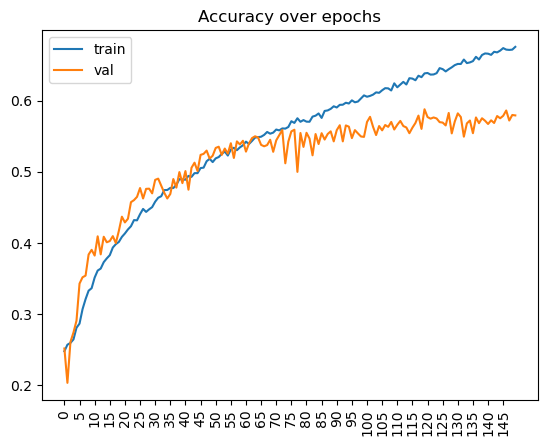

In [96]:
plt.plot(final_with_aug_history.history["accuracy"], label="train")
plt.plot(final_with_aug_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(0,150,5), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

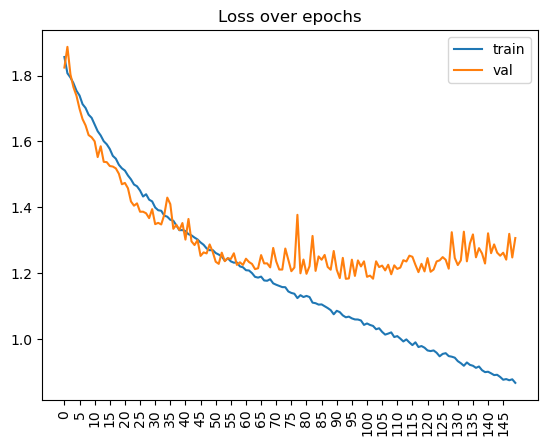

In [95]:
plt.plot(final_with_aug_history.history["loss"], label="train")
plt.plot(final_with_aug_history.history["val_loss"], label="val")
plt.xticks(np.arange(0,150,5), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Evaluate final models with test dataset

I have built a couple of final models: one without augmenting the training set and one with data augmentation. The validation dataset seems to perform better on the model with data augmentation but is this true of the test dataset?

In [99]:
test_data_folder = data_file_path + "test/"

meta_test = get_image_meta(test_data_folder)

df_meta_test = pd.DataFrame(meta_test)

test_labels = df_meta_test["category"].values
test_image_paths = df_meta_test["file_path"].values

test_dataset = create_dataset(test_image_paths, test_labels, label_encoder, should_augment_image=False, batch_size=32)

len(test_dataset) * 32 # should be roughly the size of the test data

3488

In [101]:
final_model_no_aug_filepath = "./data/er_final_46_0.557.keras"
final_model_no_aug = keras.models.load_model(final_model_no_aug_filepath)

loss, accuracy = final_model_no_aug.evaluate(test_dataset)
loss, accuracy

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5461 - loss: 1.3946


(1.4295884370803833, 0.5384172797203064)

In [102]:
final_model_no_aug_dropout_filepath = "./data/er_final_with_dr_51_0.582.keras"
final_model_no_aug_dropout = keras.models.load_model(final_model_no_aug_dropout_filepath)

loss, accuracy = final_model_no_aug_dropout.evaluate(test_dataset)
loss, accuracy

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5704 - loss: 1.2330


(1.257077932357788, 0.5663309097290039)

In [103]:
final_model_with_aug_filepath = "./er_final_with_aug_120_0.588.keras"
final_model_with_aug = keras.models.load_model(final_model_with_aug_filepath)

loss, accuracy = final_model_with_aug.evaluate(test_dataset)
loss, accuracy

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5713 - loss: 1.1743


(1.1503429412841797, 0.5801438689231873)

**Conclusions**

The Evaluation seems to confirm the results of our validation dataset: our final model trained with data augmentation has the best results. It has both a higher accuracy score and a lower loss, just slightly beating our final model with dropout.

Although `0.5713` isn't a great accuracy score - our model is only slightly better than flipping a coin! It is better than our initial model.

In [106]:
# plot_model(final_model_no_aug, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Use the model

Below we use the model to predict one of our test images. The model successfully predicts that the image shows a person who looks angry.

In [127]:
path = data_file_path + "test/sad/PrivateTest_366361.jpg"
img = preprocess_input(path, should_augment_image=False)
img = tf.expand_dims(
    img, axis=0
)
img.shape

TensorShape([1, 48, 48, 1])

In [128]:
pred = final_model_with_aug.predict(img)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[7.27518141e-01, 8.43557995e-03, 1.41286314e-01, 9.44718122e-05,
        7.80838673e-06, 1.21128574e-01, 1.52920245e-03]], dtype=float32)

In [129]:
predicted_class_index = np.argmax(pred)
predicted_class_index

np.int64(0)

In [130]:
categories = list(df_meta_train["category"].unique())
categories

['sad', 'neutral', 'fear', 'surprise', 'disgust', 'angry', 'happy']

In [131]:
dict(zip(categories,pred.tolist()[0]))

{'sad': 0.7275181412696838,
 'neutral': 0.00843557994812727,
 'fear': 0.14128631353378296,
 'surprise': 9.447181219002232e-05,
 'disgust': 7.80838672653772e-06,
 'angry': 0.12112857401371002,
 'happy': 0.0015292024472728372}

In [132]:
inverse_lookup = tf.keras.layers.StringLookup(vocabulary=categories, output_mode='int', num_oov_indices=0, mask_token=None, invert=True)

predicted_label= inverse_lookup(predicted_class_index)
predicted_label.numpy()

b'sad'

In [133]:
categories[predicted_class_index]

'sad'